O objetivo do projeto é Identificar possíveis clientes de churn com base em seu comportamento, caracteristicas demográficas e gêneros. Ou seja, que costumavam comprar com frequência na loja e de maneira repentina cessaram as mesmas. Vamos usar algumas técnicas de Machine Learning para projetarmos o melhor modelo e depois avaliarmos qual será a mais promissora e eficaz.

https://scikit-learn.org/stable/modules/ensemble.html

https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

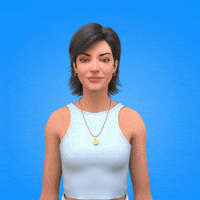

# Importando as bibliotecas e algumas funções

In [ ]:
# Gráficos e análise de dados
import plotly.express as px 
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import axes as ax

#Engenharia de Features
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from sklearn.preprocessing import LabelEncoder
from datetime import datetime, date
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV

# Algorítimos de Machine Learning
from sklearn.metrics import plot_confusion_matrix, accuracy_score, recall_score, precision_score, plot_roc_curve
from sklearn.metrics import classification_report
from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Código para limitação de linhas e colunas
pd.options.display.max_columns=999
pd.options.display.max_rows=999

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importando os dados 

client_id: ID global único do cliente

birthdate: data de nascimento do cliente

state: estado onde o cliente mora

gender: gênero declarado pelo cliente

is_churn: variável dependente (target) que diz se o cliente será churn ou não

In [ ]:
df_treino = pd.read_csv("/content/drive/MyDrive/client.treino_magalu.csv", sep=',', encoding='utf-8')
df_treino.head(5)

,client_id,birthdate,state,gender,is_churn
0,cx06840,1982-12-03,st15,cg1,False
1,cx01931,1979-05-09,st15,cg1,False
2,cx35431,1965-05-09,st15,cg1,False
3,cx36233,1954-03-15,st15,cg2,False
4,cx13540,1965-06-19,st15,cg1,False


In [ ]:
df_teste = pd.read_csv("/content/drive/MyDrive/client.test_magalu.csv", sep=',', encoding='utf-8')
df_teste.head(5)

,client_id,birthdate,state,gender,is_churn
0,cx06840,1982-12-03,st15,cg1,False
1,cx01931,1979-05-09,st15,cg1,False
2,cx35431,1965-05-09,st15,cg1,False
3,cx36233,1954-03-15,st15,cg2,False
4,cx13540,1965-06-19,st15,cg1,False


order_id: identificador da venda; pode estar repetida em outras linhas, pois cada linha corresponde à compra de um produto por um cliente, que pode ter comprado outros produtos no mesmo evento.

(client_id): identificador do cliente que realizou a compra

(datetime): data e hora da compra

(units): quantidade de unidades do produto que foram comprados nesse evento de compra

(price): preço unitário do produto comprado

(payment_method): forma de pagamento (crétido, débito, voucher, etc) da compra

(installments): número de parcelas do pagamento; se estiver vazio, pode-se considerar que não se aplica

(delivery_days): prazo de entrega do produto

(delivery_state): estado onde ocorreu a entrega do produto; corresponde exatamente ao estado nas tabelas de cliente

(device): meio por onde o cliente comprou; e.g. site, aplicativo do celular, terminal de compras

(source): canal de marketing que gerou o lead e ocasionou ao cliente comprar; por exemplo, pode ser um link em uma página parceira onde o cliente viu uma promoção

In [ ]:
Historico_vendas = pd.read_csv('/content/drive/MyDrive/ordersMagalu.csv')
Historico_vendas.head(3)

,order_id,client_id,product_id,datetime,units,price,payment_method,installments,delivery_days,delivery_state,device,source
0,ox008433,cx05072,px04611,2019-10-07 15:20:00,1.0,49.9,pm05,NaN,NaN,st07,dv9,sc08
1,ox070389,cx05072,px12305,2019-10-11 17:42:00,1.0,69.9,pm05,NaN,NaN,st07,dv9,sc08
2,ox061137,cx06840,px07033,2019-01-19 13:09:00,1.0,35.9,pm05,NaN,NaN,st07,dv9,sc08


category_lv0: Categorias mais abrangentes dos produtos; e.g. "Eletrônicos" ou "Moda"

category_lv1: Subcategorias; e.g. "Eletrônicos->Notebooks"

category_lv2: Sub-subcategorias; e.g. "Eletrônicos->Notebooks->UltraFinos"

In [ ]:
produtos= pd.read_csv('/content/drive/MyDrive/productMagalu.csv')
produtos.head(3)

,product_id,category_lv0,category_lv1,category_lv2,category_lv3,category_lv4
0,px01237,mk38,mk38:072,mk38:072:149,mk38:072:149:218,mk38:072:149:218:04846
1,px11510,mk38,mk38:072,mk38:072:149,mk38:072:149:218,mk38:072:149:218:01337
2,px03782,mk38,mk38:072,mk38:072:019,mk38:072:019:066,mk38:072:019:066:02321


# Análise geral dos dados

## Base 1 

In [ ]:
df_treino.shape

(7764, 5)

In [ ]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7764 entries, 0 to 7763
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  7764 non-null   object
 1   birthdate  7764 non-null   object
 2   state      7764 non-null   object
 3   gender     7764 non-null   object
 4   is_churn   7764 non-null   bool  
dtypes: bool(1), object(4)
memory usage: 250.3+ KB


In [ ]:
df_teste.shape

(7764, 5)

In [ ]:
df_teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7764 entries, 0 to 7763
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  7764 non-null   object
 1   birthdate  7764 non-null   object
 2   state      7764 non-null   object
 3   gender     7764 non-null   object
 4   is_churn   7764 non-null   bool  
dtypes: bool(1), object(4)
memory usage: 250.3+ KB


## base 2

In [ ]:
Historico_vendas.shape

(168472, 12)

In [ ]:
Historico_vendas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168472 entries, 0 to 168471
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   order_id        168472 non-null  object 
 1   client_id       168472 non-null  object 
 2   product_id      168472 non-null  object 
 3   datetime        168472 non-null  object 
 4   units           168472 non-null  float64
 5   price           168472 non-null  float64
 6   payment_method  168472 non-null  object 
 7   installments    36545 non-null   float64
 8   delivery_days   89642 non-null   float64
 9   delivery_state  168472 non-null  object 
 10  device          168472 non-null  object 
 11  source          168472 non-null  object 
dtypes: float64(4), object(8)
memory usage: 15.4+ MB


In [ ]:
produtos.shape

(12659, 6)

In [ ]:
produtos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12659 entries, 0 to 12658
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_id    12659 non-null  object
 1   category_lv0  12659 non-null  object
 2   category_lv1  12659 non-null  object
 3   category_lv2  12659 non-null  object
 4   category_lv3  12659 non-null  object
 5   category_lv4  12659 non-null  object
dtypes: object(6)
memory usage: 593.5+ KB


# Verificando Valores nulos 

In [ ]:
df_treino.isna().mean()

client_id    0.0
birthdate    0.0
state        0.0
gender       0.0
is_churn     0.0
dtype: float64

In [ ]:
df_teste.isna().mean()

client_id    0.0
birthdate    0.0
state        0.0
gender       0.0
is_churn     0.0
dtype: float64

In [ ]:
Historico_vendas.isna().mean()

order_id          0.000000
client_id         0.000000
product_id        0.000000
datetime          0.000000
units             0.000000
price             0.000000
payment_method    0.000000
installments      0.783080
delivery_days     0.467912
delivery_state    0.000000
device            0.000000
source            0.000000
dtype: float64

In [ ]:
produtos.isna().mean()

product_id      0.0
category_lv0    0.0
category_lv1    0.0
category_lv2    0.0
category_lv3    0.0
category_lv4    0.0
dtype: float64

# Análise estatística geral dos dados

In [ ]:
df_treino.describe().T

,count,unique,top,freq
client_id,7764,7764,cx06840,1
birthdate,7764,6252,1990-01-01,18
state,7764,25,st15,2723
gender,7764,2,cg1,4241
is_churn,7764,2,False,6368


In [ ]:
Historico_vendas.describe().T

,count,mean,std,min,25%,50%,75%,max
units,168472.0,1.228846,1.504511,0.0,1.0,1.00,1.0,110.0
price,168472.0,451.384291,857.769280,-8999.0,39.9,162.58,699.0,25648.9
installments,36545.0,4.551293,4.704385,1.0,1.0,3.00,7.0,24.0
delivery_days,89642.0,7.017938,6.855334,0.0,2.0,5.00,9.0,165.0


In [ ]:
produtos.describe().T

,count,unique,top,freq
product_id,12659,12659,px01237,1
category_lv0,12659,52,mk17,1273
category_lv1,12659,296,mk21:089,563
category_lv2,12659,893,mk03:092:378,237
category_lv3,12659,1218,mk03:092:378:103,237
category_lv4,12659,10763,mk35:072:177:182:09721,10


# Tratamento e engenharia de features 

In [ ]:
df_train = pd.merge(df_treino, Historico_vendas,  how='left', on='client_id') #left_on, right_on, para nomes diferentes!
df_train.head(2)

,client_id,birthdate,state,gender,is_churn,order_id,product_id,datetime,units,price,payment_method,installments,delivery_days,delivery_state,device,source
0,cx06840,1982-12-03,st15,cg1,False,ox061137,px07033,2019-01-19 13:09:00,1.0,35.9,pm05,NaN,NaN,st07,dv9,sc08
1,cx06840,1982-12-03,st15,cg1,False,ox061137,px05992,2019-01-19 13:09:00,3.0,35.9,pm05,NaN,NaN,st07,dv9,sc08


In [ ]:
df_train.shape

(33860, 16)

In [ ]:
df_train = df_train.drop_duplicates()

In [ ]:
colunas_2 = ['delivery_days' ]

imputer_2 = SimpleImputer(strategy='mean')
imputer_2.fit(df_train[colunas_2])
df_train[colunas_2] = imputer_2.transform(df_train[colunas_2])

In [ ]:
df_train['installments'] = df_train['installments'].fillna(0)

In [ ]:
df_train.head(2)

,client_id,birthdate,state,gender,is_churn,order_id,product_id,datetime,units,price,payment_method,installments,delivery_days,delivery_state,device,source
0,cx06840,1982-12-03,st15,cg1,False,ox061137,px07033,2019-01-19 13:09:00,1.0,35.9,pm05,0.0,7.094401,st07,dv9,sc08
1,cx06840,1982-12-03,st15,cg1,False,ox061137,px05992,2019-01-19 13:09:00,3.0,35.9,pm05,0.0,7.094401,st07,dv9,sc08


# Engenharia de Features

In [ ]:
df_train['datetime'] = pd.to_datetime(df_train['datetime'], format = '%Y-%m-%d')
df_train['birthdate'] = pd.to_datetime(df_train['birthdate'], format = '%Y-%m-%d')

In [ ]:
def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

df_train['age'] = df_train['birthdate'].apply(calculate_age)

In [ ]:
bins = [-1, 0, 5, 10, 12 ,18, 24]
labels = ['0x', 'até 5x', '5x até 10x', '10x até 12', '12x até 18', '18x até 24x']
df_train['Parcelas'] = pd.cut(df_train['installments'], bins=bins, labels=labels)
pd.value_counts(df_train.Parcelas)

0x             26539
até 5x          5053
5x até 10x      1861
10x até 12       182
18x até 24x      170
12x até 18        55
Name: Parcelas, dtype: int64

In [ ]:
bins = [-1, 0, 7, 10, 20, 30, 40, 50, 63 ]
labels = ['sem prazo de entrega', '0 até 7 dias ','7 até 10 dias ', '10  até 20 dias ', '20  até 30 dias  ', ' 30 até 40 dias   ', '40 até 50 dias', '50 até 63 dias']
df_train['Prazo_entrega'] = pd.cut(df_train['delivery_days'],bins=bins, labels=labels)
pd.value_counts(df_train.Prazo_entrega)


7 até 10 dias           18268
0 até 7 dias            10895
10  até 20 dias          2947
sem prazo de entrega      919
20  até 30 dias           601
 30 até 40 dias           131
40 até 50 dias             53
50 até 63 dias             46
Name: Prazo_entrega, dtype: int64

In [ ]:
bins = [ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130 ]
labels = [ '0 a 10 anos ','10 a 20 anos  ', '20  a 30 anos ', '30  a 40 anos  ', ' 40 a 50 anos   ', '50 a 60 anos', '60 a 70 anos', '70 a 80 anos', '80 a 90 anos', '90 a 100 anos', '100 a 110 anos', '110 a 120 anos', '120 a 130 anos' ]
df_train['Faixa_idade'] = pd.cut(df_train['age'],bins=bins, labels=labels)
pd.value_counts(df_train.Faixa_idade)

30  a 40 anos       10669
 40 a 50 anos        7932
50 a 60 anos         5471
20  a 30 anos        4558
60 a 70 anos         3706
70 a 80 anos         1206
80 a 90 anos          235
10 a 20 anos           63
90 a 100 anos          10
120 a 130 anos         10
0 a 10 anos             0
100 a 110 anos          0
110 a 120 anos          0
Name: Faixa_idade, dtype: int64

# Análises exploratórias

Bom! Após fazer uma análise geral e tratamento nos dados, vou seguir com EDA com os recursos adicionados no dataset.

In [ ]:
df_train = df_train.drop(columns= ['delivery_days', 'installments'] )

In [ ]:
df_train.head(2)

,client_id,birthdate,state,gender,is_churn,order_id,product_id,datetime,units,price,payment_method,delivery_state,device,source,age,Parcelas,Prazo_entrega,Faixa_idade
0,cx06840,1982-12-03,st15,cg1,False,ox061137,px07033,2019-01-19 13:09:00,1.0,35.9,pm05,st07,dv9,sc08,40,0x,7 até 10 dias,30 a 40 anos
1,cx06840,1982-12-03,st15,cg1,False,ox061137,px05992,2019-01-19 13:09:00,3.0,35.9,pm05,st07,dv9,sc08,40,0x,7 até 10 dias,30 a 40 anos


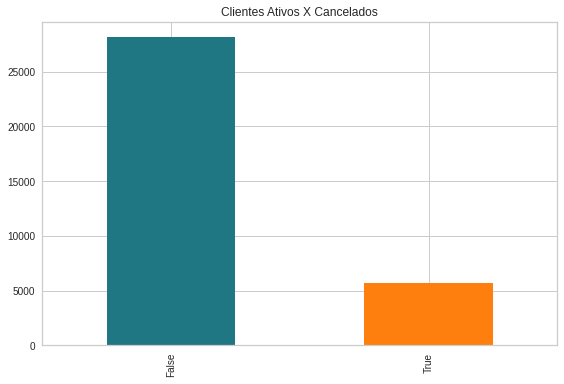

In [ ]:
plt.rcParams['figure.figsize']==[12.00, 5.00]
plt.rcParams['figure.autolayout']=True
df_train.is_churn.value_counts().plot(kind='bar', title = 'Clientes Ativos X Cancelados', color=['#1F7784', '#FF7F0E'])

Primeiro vamos verificar a proporção de dados da nossa variavél target e olhando para o gráfico acima vemos que eles estão desbalanceados. 

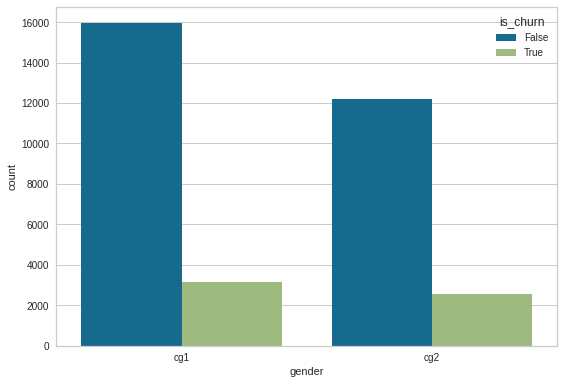

In [ ]:
plt.rcParams['figure.figsize']==[12.00, 3.50]
plt.rcParams['figure.autolayout']=True
sns.countplot(data=df_train, x='gender', hue='is_churn')
plt.show()

Ao verificar o gráfico acima o genêro cg1 é o grupo que são mais churns, porém com pouca diferença em relação ao cg2 

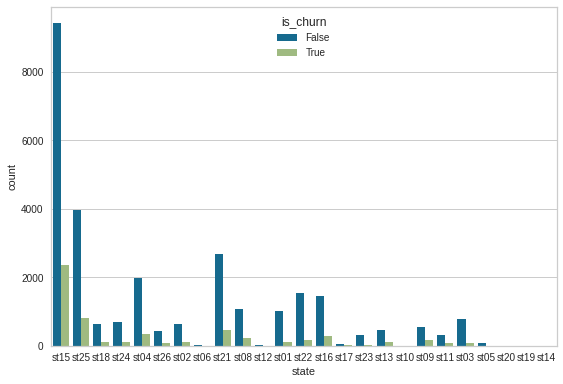

In [ ]:
plt.rcParams['figure.figsize']==[12.00, 3.50]
plt.rcParams['figure.autolayout']=True
sns.countplot(data=df_train, x='state', hue='is_churn')
plt.show()

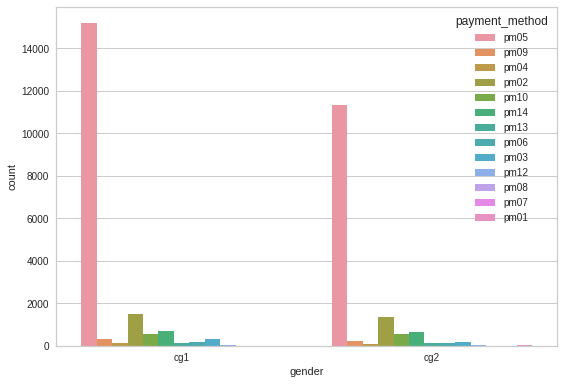

In [ ]:
plt.rcParams['figure.figsize']==[20.00, 4.50]
plt.rcParams['figure.autolayout']=True
sns.countplot(data=df_train, x='gender', hue='payment_method')
plt.show()

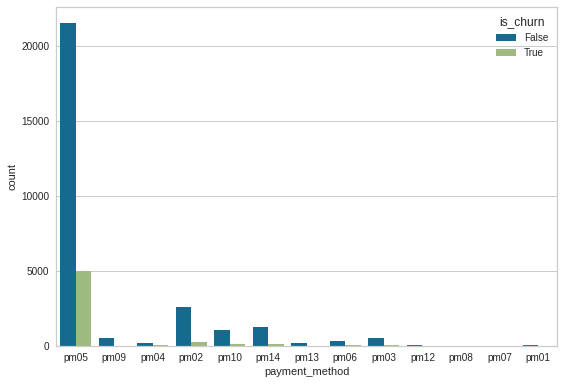

In [ ]:
plt.rcParams['figure.figsize']==[12.00, 3.50]
plt.rcParams['figure.autolayout']=True
sns.countplot(data=df_train, x='payment_method', hue='is_churn')
plt.show()

In [ ]:
fig = px.histogram(df_train, x="age") 
fig.show()  

Temos clientes muito jovens e muito velhos. Podemos deduzir também que é algum erro de digitação ou os clientes mais velhos morreram e ai seus cadastros ficaram na base de dados dando um possível churn. 

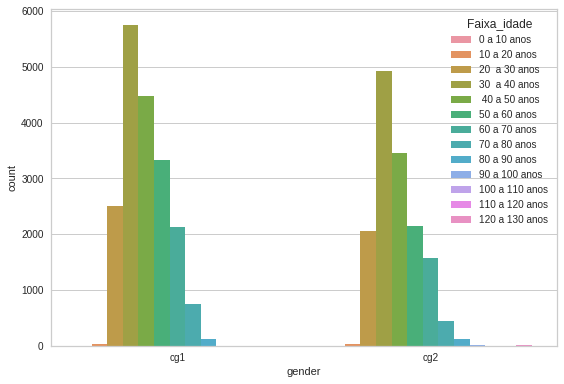

In [ ]:
plt.rcParams['figure.figsize']==[12.00, 3.50]
plt.rcParams['figure.autolayout']=True
sns.countplot(data=df_train, x='gender', hue='Faixa_idade')
plt.show()

A idade entre os genêros aparentemente estão mais ou menos proporcionais entre eles. Até parece uma distribuição normal, mas temos idades que provavelmente são de pessoas que não existem mais ou erro na base dados,por isso essa assimetria nos dados. 

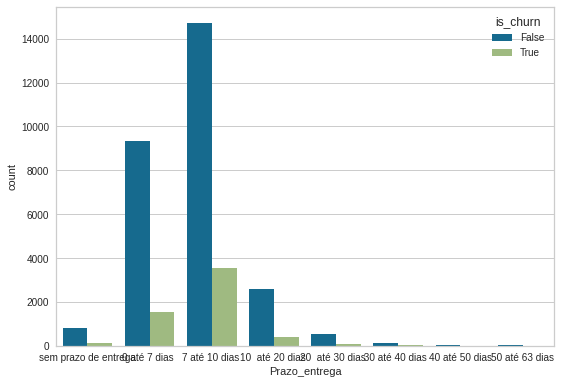

In [ ]:
plt.rcParams['figure.figsize']==[12.00, 3.50]
plt.rcParams['figure.autolayout']=True
sns.countplot(data=df_train, x='Prazo_entrega', hue='is_churn')
plt.show()

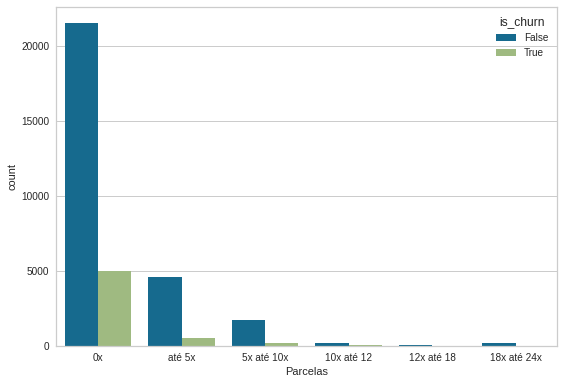

In [ ]:
plt.rcParams['figure.figsize']==[12.00, 3.50]
plt.rcParams['figure.autolayout']=True
sns.countplot(data=df_train, x='Parcelas', hue='is_churn')
plt.show()

## Análise das variáveis numéricas

In [ ]:
variaveis_numericas=[]
for i in df_train.columns[0:18].tolist():
  if df_train.dtypes[i]=='int64' or df_train.dtypes[i]=='float64':
    print(i, ':', df_train.dtypes[i])
    variaveis_numericas.append(i)

units : float64
price : float64
age : int64


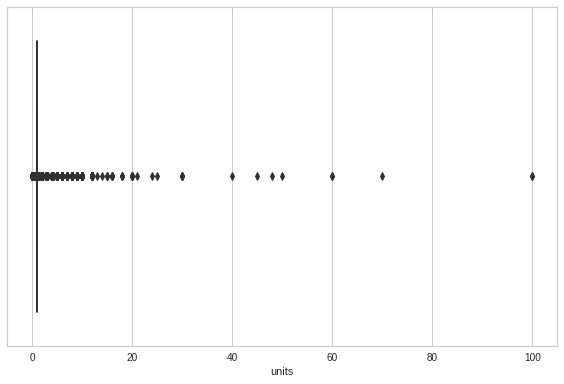

In [ ]:
sns.boxplot(x= df_train['units'])

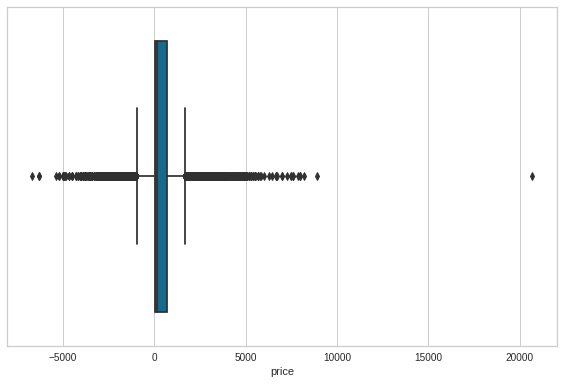

In [ ]:
sns.boxplot(x= df_train['price'])

Bom, verificando os dois boxplot. Temos muitos outliers,  a variável preço tem valores abaixo de zero, não sabemos se é um possivel estorno de compras ou algum erro de digitação. Já a variável unidades de itens também tem um valor muito discrepantes dos demais, porém não sei se nesse caso é correto excluir os outliers porque de uma certa forma esses valores podem ser sim uma certa informação e por o mesmo ser dados reais. 

# Transformações nos dados 

In [ ]:
dados = df_train[['state','gender','is_churn',	'units', 	'price', 'payment_method', 'delivery_state', 'age', 'Parcelas', 'Prazo_entrega']]
dados.head(1)

,state,gender,is_churn,units,price,payment_method,delivery_state,age,Parcelas,Prazo_entrega
0,st15,cg1,False,1.0,35.9,pm05,st07,40,0x,7 até 10 dias


In [ ]:
variaveis_categoricas = []
for i in dados.columns[0:10].tolist():
        if dados.dtypes[i] == 'object' or dados.dtypes[i] == 'category':                        
            variaveis_categoricas.append(i)    

In [ ]:
variaveis_categoricas

['state',
 'gender',
 'payment_method',
 'delivery_state',
 'Parcelas',
 'Prazo_entrega']

In [ ]:
lb = LabelEncoder()

for var in variaveis_categoricas:
    dados[var] = lb.fit_transform(dados[var])

<ipython-input-99-6dbbfd2a1fb7>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
dados.head(2)

,state,gender,is_churn,units,price,payment_method,delivery_state,age,Parcelas,Prazo_entrega
0,13,0,False,1.0,35.9,4,6,40,0,6
1,13,0,False,3.0,35.9,4,6,40,0,6


In [ ]:
x = dados.drop(columns=['is_churn'])

In [ ]:
x.head(1)

,state,gender,units,price,payment_method,delivery_state,age,Parcelas,Prazo_entrega
0,13,0,1.0,35.9,4,6,40,0,6


In [ ]:
y = dados[['is_churn']]
y.head(1)

,is_churn
0,False


In [ ]:
y['is_churn'] = lb.fit_transform(y['is_churn'])

<ipython-input-104-c47acc842b90>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
seed = 100
balanceador = SMOTE(random_state = seed)
predict, target = balanceador.fit_resample(x, y)

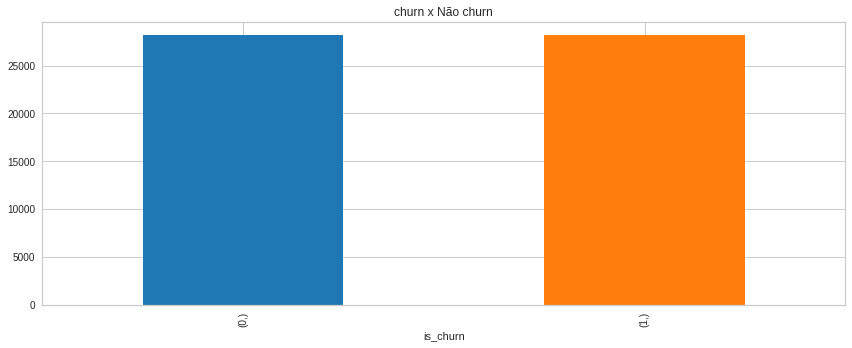

In [ ]:
plt.rcParams["figure.figsize"] = [12.00, 5.00]
plt.rcParams["figure.autolayout"] = True
target.value_counts().plot(kind='bar', title='churn x Não churn',color = ['#1F77B4', '#FF7F0E']);

In [ ]:
x_treino, x_teste, y_treino, y_teste = train_test_split(predict, target, test_size = 0.3, random_state = 42)

In [ ]:
y_teste.value_counts(normalize=True)

is_churn
1           0.50003
0           0.49997
dtype: float64

In [ ]:
y_treino.value_counts(normalize=True)

is_churn
0           0.500013
1           0.499987
dtype: float64

In [ ]:
Normalizador = MinMaxScaler()
x_treino_normalizados = Normalizador.fit_transform(x_treino)
x_teste_normalizados = Normalizador.transform(x_teste)

In [ ]:
df_x_treino = pd.DataFrame(x_treino_normalizados)

In [ ]:
df_x_teste = pd.DataFrame(x_teste_normalizados)

# Ensamble - Machine Learning

## Testes

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)

In [ ]:
results = cross_val_score(rfc, x_teste_normalizados, y_teste, cv=skf, error_score='raise',verbose=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (

In [ ]:
results

array([0.77639752, 0.78313609, 0.78254438, 0.79201183, 0.78461538])

In [ ]:
results_2 = cross_val_score(rfc, x_treino_normalizados, y_treino, cv=skf, error_score='raise',verbose=1)

In [ ]:
results_2

array([0.83060733, 0.82629644, 0.83162166, 0.82743756, 0.82971979])

In [ ]:
print("CV accuracy score: {:.2f}%".format(results.mean() * 100))

CV accuracy score: 78.37%


In [ ]:
print("CV accuracy score: {:.2f}%".format(results_2.mean() * 100))

CV accuracy score: 82.91%


Acurácia nos dados de treino está prevendo 83% de churns, já nos dados de teste a detecção de churns é de 79%, Mas podemos melhorar!!!

## Machine Learning

## Decision Tree

In [ ]:
arvore = DecisionTreeClassifier(criterion='entropy')
arvore.fit(x_treino_normalizados, y_treino)

DecisionTreeClassifier(criterion='entropy')

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



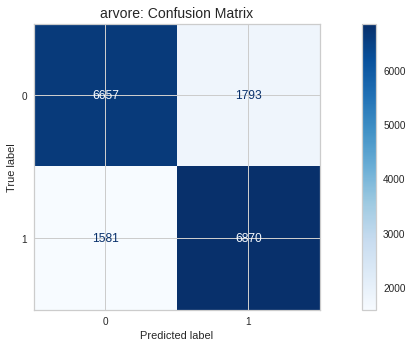

In [ ]:
plot_confusion_matrix(arvore, x_teste_normalizados, y_teste,cmap='Blues')
plt.title('arvore: Confusion Matrix', fontsize=14)
plt.show()

In [ ]:
6870/8663 # recall 79%  

0.7930278194620801

In [ ]:
(6657+6870)/16901 # 80%

0.8003668421986865

In [ ]:
6870/8451 # 81% 

0.8129215477458289

In [ ]:
previsao_tree = arvore.predict(x_teste_normalizados) 
previsao_tree

array([1, 1, 1, ..., 0, 1, 0])

In [ ]:
print(classification_report(y_teste, previsao_tree))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      8450
           1       0.79      0.81      0.80      8451

    accuracy                           0.80     16901
   macro avg       0.80      0.80      0.80     16901
weighted avg       0.80      0.80      0.80     16901



In [ ]:
scores = arvore.score(x_teste_normalizados,y_teste)
scores

0.8003668421986865

## XGBoost

In [ ]:
xgb = XGBClassifier()
xgb.fit(x_treino_normalizados , y_treino)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



XGBClassifier()

In [ ]:
xgb_preds=xgb.predict(x_teste_normalizados)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



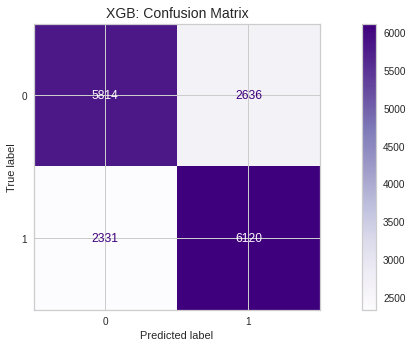

In [ ]:
plot_confusion_matrix(xgb, x_teste_normalizados, y_teste,cmap='Purples')
plt.title('XGB: Confusion Matrix', fontsize=14)
plt.show()

In [ ]:
print(classification_report(y_teste, xgb_preds))

              precision    recall  f1-score   support

           0       0.71      0.69      0.70      8450
           1       0.70      0.72      0.71      8451

    accuracy                           0.71     16901
   macro avg       0.71      0.71      0.71     16901
weighted avg       0.71      0.71      0.71     16901



## Random Forest Classifier

In [ ]:
clf = RandomForestClassifier(n_estimators  = 300)
clf = clf.fit(x_treino_normalizados, y_treino)

<ipython-input-90-a4c4e381a9ad>:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



In [ ]:
previsao = clf.predict(x_teste_normalizados) 
previsao

array([1, 1, 1, ..., 0, 1, 0])

In [ ]:
scores = clf.score(x_teste_normalizados,y_teste)
scores

0.839654458316076

0.839654458316076

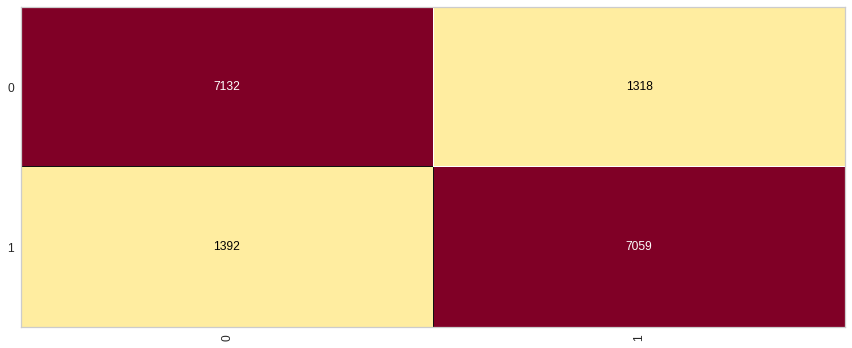

In [ ]:
cm=ConfusionMatrix(clf)
cm.fit(x_teste_normalizados, y_teste)
cm.score(x_teste_normalizados, y_teste)

In [ ]:
print(classification_report(y_teste, previsao))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      8450
           1       0.84      0.84      0.84      8451

    accuracy                           0.84     16901
   macro avg       0.84      0.84      0.84     16901
weighted avg       0.84      0.84      0.84     16901



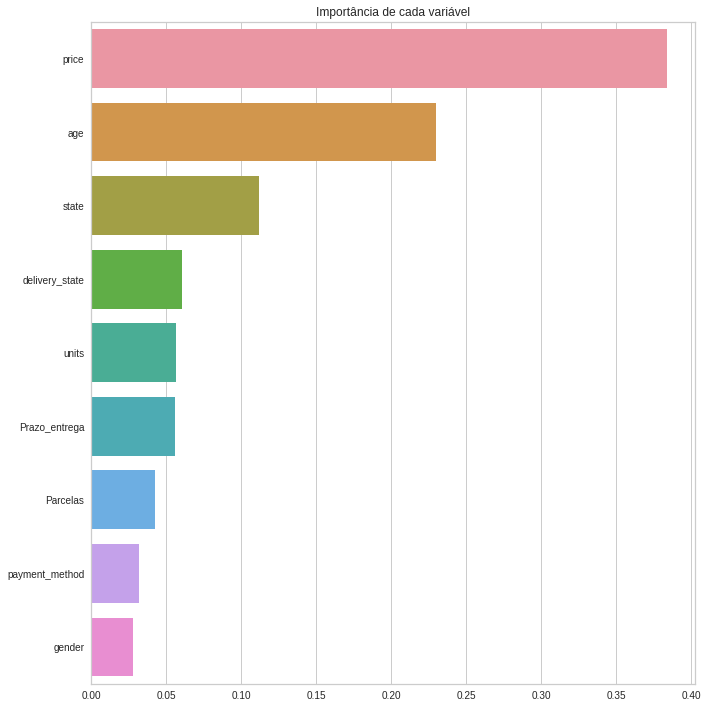

In [ ]:
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True

importances = pd.Series(data=clf.feature_importances_, index=predict.columns)
importances = importances.sort_values(ascending = False)
sns.barplot(x=importances, y=importances.index, orient='h').set_title('Importância de cada variável')
plt.show()